### 0. Preparing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
peaks_data = pd.read_csv("peaks_tss_distance.csv")

In [4]:
peaks_stats = pd.read_csv("peak_stats.csv")

In [5]:
peaks_data.head()

,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss
0,ImmGenATAC1219.peak_1,chr1,3020786,3671498.0,650712.0
1,ImmGenATAC1219.peak_2,chr1,3087226,3671498.0,584272.0
2,ImmGenATAC1219.peak_3,chr1,3120109,3671498.0,551389.0
3,ImmGenATAC1219.peak_4,chr1,3121485,3671498.0,550013.0
4,ImmGenATAC1219.peak_5,chr1,3372787,3671498.0,298711.0


### 1. Comparing Promoters and Enhancers

##### A. Defining Promoters and Enhancers

<dir align="justify">
In this part we are defining regions that could be promoters or enhancers based on the distance between peaks and TSS. It should be noted that this method is not precise. We cannot be sure whether a specific region is an enhancer without looking into  the correlation of its accessibility with gene expression. However, it does give us some candidates that could potentially be considered as CREs. 
</dir>

In [6]:
peaks_data["RegionType"] = peaks_data["distance_to_tss"].apply(
    lambda x: "Promoter" if x <= 1000 else "Enhancer"
)

In [7]:
peaks_data.head()

,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss,RegionType
0,ImmGenATAC1219.peak_1,chr1,3020786,3671498.0,650712.0,Enhancer
1,ImmGenATAC1219.peak_2,chr1,3087226,3671498.0,584272.0,Enhancer
2,ImmGenATAC1219.peak_3,chr1,3120109,3671498.0,551389.0,Enhancer
3,ImmGenATAC1219.peak_4,chr1,3121485,3671498.0,550013.0,Enhancer
4,ImmGenATAC1219.peak_5,chr1,3372787,3671498.0,298711.0,Enhancer


In [8]:
peaks_stats.head()

,ImmGenATAC1219.peakID,Mean,Median,SD,CV
0,ImmGenATAC1219.peak_1,0.807586,0.71,0.720603,0.892293
1,ImmGenATAC1219.peak_2,1.135517,0.90,0.920999,0.811084
2,ImmGenATAC1219.peak_3,0.688621,0.40,0.745341,1.082369
3,ImmGenATAC1219.peak_4,0.788621,0.53,0.882103,1.118539
4,ImmGenATAC1219.peak_5,0.697586,0.51,0.571493,0.819244


In [9]:
print(peaks_data["distance_to_tss"].min())
print(peaks_data["distance_to_tss"].max())

0.0
2012626.0


##### B. Comparing the mean ATAC signal with violinplots

In [27]:
merged = pd.merge(peaks_data, peaks_stats, on="ImmGenATAC1219.peakID")

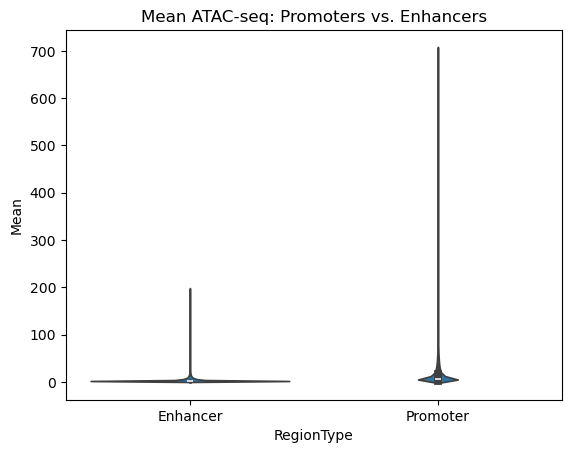

In [ ]:
sns.violinplot(data=merged, x="RegionType", y="Mean")
plt.title("Mean ATAC-seq: Promoters vs. Enhancers")
plt.tight_layout
plt.show()


Due to some peaks having very high values, it is difficult to discern the boxplots. Therefore, the data is plotted again in a log-scale.

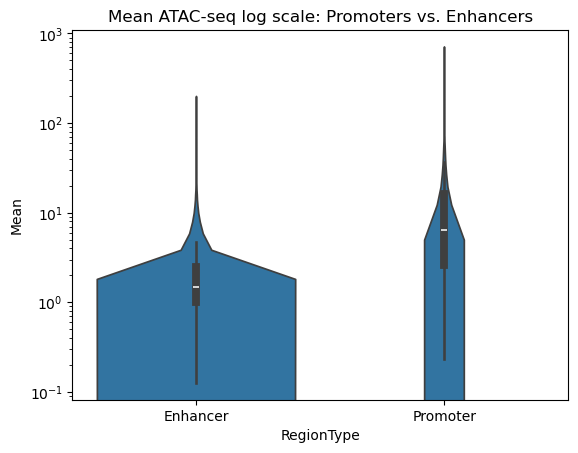

In [16]:
sns.violinplot(data=merged, x="RegionType", y="Mean")
plt.yscale("log")
plt.title("Mean ATAC-seq log scale: Promoters vs. Enhancers")
plt.tight_layout
plt.show()

### 2. Performing statistical tests

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu

prom = merged[merged["RegionType"] == "Promoter"]["Mean"]
enh = merged[merged["RegionType"] == "Enhancer"]["Mean"]

# t-test
t_stat, p_ttest = ttest_ind(prom, enh, equal_var=False)

# Mann–Whitney (non-parametric)
u_stat, p_mw = mannwhitneyu(prom, enh)

print(f"T-test p = {p_ttest:.4g}")
print(f"Mann-Whitney p = {p_mw:.4g}")


T-test p = 0
Mann–Whitney p = 0


<div align="justify">
The tests did take fairly long to load. That is why the following code looks only at a random portion of the CREs. Anyhow, the tests show extremely small values that are rounded to 0. Therefore, the H<sub>0</sub> hypothesis (i.e. the two types of regions having the same distribution of signal) can be rejected. 
</div>

In [ ]:
prom_sample = prom.sample(n=10000, random_state=1)
enh_sample = enh.sample(n=10000, random_state=1)

_, p = mannwhitneyu(prom_sample, enh_sample)
print(f"Mann-Whitney p = {p:.4g}")


Mann–Whitney p = 0


### 3. Intronic vs. intergenic enhancers

In [28]:
ref = pd.read_csv("refFlat", sep="\t", header=None)

In [29]:
ref.columns = [
    "gene_name", "transcript_name", "chrom", "strand",
    "tx_start_5prime", "tx_start_3prime",
    "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]


In [ ]:
#I did not use this code later. But I am leaving it here just in case. It would help us define whether the regions lie within exons.
#But executing the code after that took too long and I gave up on this.

exon_rows = []

for _, row in ref.iterrows():
    chrom = row["chrom"]
    starts = list(map(int, row["exon_starts"].rstrip(',').split(',')))
    ends = list(map(int, row["exon_ends"].rstrip(',').split(',')))
    
    for start, end in zip(starts, ends):
        exon_rows.append({"chrom": chrom, "start": start, "end": end})

exon_df = pd.DataFrame(exon_rows)


In [14]:
ref.head()

,gene_name,transcript_name,chrom,strand,tx_start_5prime,tx_start_3prime,cds_start,cds_end,exon_count,exon_starts,exon_ends
0,Wdsub1,NM_001159636,chr2,-,59855193,59882606,59855270,59878527,11,"59855193,59858609,59861560,59862619,59862816,5...","59855275,59858750,59861737,59862726,59862857,5..."
1,Rbm18,NM_001159635,chr2,-,36116078,36136704,36117814,36134247,6,"36116078,36120812,36122851,36127214,36134134,3...","36117974,36120898,36122938,36127251,36134263,3..."
2,Prrc2b,NM_001159634,chr2,+,32151147,32234537,32182511,32230742,32,"32151147,32182457,32183122,32185344,32187480,3...","32151291,32182626,32183300,32185447,32187553,3..."
3,Ildr2,NM_001164528,chr1,+,166254138,166316832,166254375,166310795,10,"166254138,166269304,166270498,166291415,166294...","166254466,166269637,166270618,166291472,166294..."
4,Perm1,NM_172417,chr4,+,156215926,156221307,156217000,156220222,4,"156215926,156216716,156219740,156220109,","156215975,156219185,156219866,156221307,"


In [31]:
genes = ref[["chrom", "tx_start_5prime", "tx_start_3prime"]].copy()
genes.columns = ["chrom", "start", "end"]

In [14]:
genes.head()

,chrom,start,end
0,chr2,59855193,59882606
1,chr2,36116078,36136704
2,chr2,32151147,32234537
3,chr1,166254138,166316832
4,chr4,156215926,156221307


In [32]:
enhancers = peaks_data[peaks_data["RegionType"] == "Enhancer"].copy()

In our data we only have information about the summit of the peak (i.e. the center), but not the start and end of the CREs around them. We can assume that all enhancers have the same length of around 600 bp. I am basing this assumption on an article that examined enhancers in mice and calculated a mean length of around 605 bp (Ben-Simon et al., 2025).

In [33]:
# 600 bp total length: +/- 300 bp around center
enhancers["start"] = enhancers["peak_center"] - 300
enhancers["end"] = enhancers["peak_center"] + 300

In [17]:
enhancers.head()

,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss,RegionType,start,end
0,ImmGenATAC1219.peak_1,chr1,3020786,3671498.0,650712.0,Enhancer,3020486,3021086
1,ImmGenATAC1219.peak_2,chr1,3087226,3671498.0,584272.0,Enhancer,3086926,3087526
2,ImmGenATAC1219.peak_3,chr1,3120109,3671498.0,551389.0,Enhancer,3119809,3120409
3,ImmGenATAC1219.peak_4,chr1,3121485,3671498.0,550013.0,Enhancer,3121185,3121785
4,ImmGenATAC1219.peak_5,chr1,3372787,3671498.0,298711.0,Enhancer,3372487,3373087


In [34]:
print(enhancers.columns)
merged.head()

Index(['ImmGenATAC1219.peakID', 'chrom', 'peak_center', 'closest_tss',
       'distance_to_tss', 'RegionType', 'start', 'end'],
      dtype='object')


,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss,RegionType,Mean,Median,SD,CV
0,ImmGenATAC1219.peak_1,chr1,3020786,3671498.0,650712.0,Enhancer,0.807586,0.71,0.720603,0.892293
1,ImmGenATAC1219.peak_2,chr1,3087226,3671498.0,584272.0,Enhancer,1.135517,0.90,0.920999,0.811084
2,ImmGenATAC1219.peak_3,chr1,3120109,3671498.0,551389.0,Enhancer,0.688621,0.40,0.745341,1.082369
3,ImmGenATAC1219.peak_4,chr1,3121485,3671498.0,550013.0,Enhancer,0.788621,0.53,0.882103,1.118539
4,ImmGenATAC1219.peak_5,chr1,3372787,3671498.0,298711.0,Enhancer,0.697586,0.51,0.571493,0.819244


In [35]:
!pip show intervaltree

Name: intervaltree


Version: 3.1.0
Summary: Editable interval tree data structure for Python 2 and 3
Home-page: https://github.com/chaimleib/intervaltree
Author: Chaim Leib Halbert, Konstantin Tretyakov
Author-email: chaim.leib.halbert@gmail.com
License: Apache License, Version 2.0
Location: c:\users\boris\miniconda3\envs\real_forked_bioinfo_project\lib\site-packages
Requires: sortedcontainers
Required-by: 


In the following chunk of code, we are defining whether the enhancers are intronic or intergenic. 

In [36]:
from intervaltree import IntervalTree

gene_trees = {}
for chrom in genes["chrom"].unique():
    intervals = IntervalTree()
    for _, row in genes[genes["chrom"] == chrom].iterrows():
        intervals[row["start"]:row["end"]] = True
    gene_trees[chrom] = intervals

def fast_is_intergenic(row):
    chrom = row["chrom"]
    start = row["start"]
    end = row["end"]
    tree = gene_trees.get(chrom)
    if tree is None: 
        return True
    return not tree.overlaps (start, end)

enhancers["is_intergenic"] = enhancers.apply(fast_is_intergenic, axis = 1)




In [37]:
print("Done!")

Done!


In [38]:
enhancers.head()

,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss,RegionType,start,end,is_intergenic
0,ImmGenATAC1219.peak_1,chr1,3020786,3671498.0,650712.0,Enhancer,3020486,3021086,True
1,ImmGenATAC1219.peak_2,chr1,3087226,3671498.0,584272.0,Enhancer,3086926,3087526,True
2,ImmGenATAC1219.peak_3,chr1,3120109,3671498.0,551389.0,Enhancer,3119809,3120409,True
3,ImmGenATAC1219.peak_4,chr1,3121485,3671498.0,550013.0,Enhancer,3121185,3121785,True
4,ImmGenATAC1219.peak_5,chr1,3372787,3671498.0,298711.0,Enhancer,3372487,3373087,False


In [39]:
enhancers.to_csv("enhancer_analysis_results.csv", index = False)

In [40]:
enhancers["EnhancerType"] = enhancers["is_intergenic"].map({True: "Intergenic", False: "Intronic"})

In [41]:
enhancers.head()

,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss,RegionType,start,end,is_intergenic,EnhancerType
0,ImmGenATAC1219.peak_1,chr1,3020786,3671498.0,650712.0,Enhancer,3020486,3021086,True,Intergenic
1,ImmGenATAC1219.peak_2,chr1,3087226,3671498.0,584272.0,Enhancer,3086926,3087526,True,Intergenic
2,ImmGenATAC1219.peak_3,chr1,3120109,3671498.0,551389.0,Enhancer,3119809,3120409,True,Intergenic
3,ImmGenATAC1219.peak_4,chr1,3121485,3671498.0,550013.0,Enhancer,3121185,3121785,True,Intergenic
4,ImmGenATAC1219.peak_5,chr1,3372787,3671498.0,298711.0,Enhancer,3372487,3373087,False,Intronic


In [43]:
peaks_stats.head()

,ImmGenATAC1219.peakID,Mean,Median,SD,CV
0,ImmGenATAC1219.peak_1,0.807586,0.71,0.720603,0.892293
1,ImmGenATAC1219.peak_2,1.135517,0.90,0.920999,0.811084
2,ImmGenATAC1219.peak_3,0.688621,0.40,0.745341,1.082369
3,ImmGenATAC1219.peak_4,0.788621,0.53,0.882103,1.118539
4,ImmGenATAC1219.peak_5,0.697586,0.51,0.571493,0.819244


In [44]:
enhancers = enhancers.merge(peaks_stats[["ImmGenATAC1219.peakID", "Mean", "Median", "SD", "CV"]], on="ImmGenATAC1219.peakID", how="left")

In [46]:
enhancers.head()

,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss,RegionType,start,end,is_intergenic,EnhancerType,Mean,Median,SD,CV
0,ImmGenATAC1219.peak_1,chr1,3020786,3671498.0,650712.0,Enhancer,3020486,3021086,True,Intergenic,0.807586,0.71,0.720603,0.892293
1,ImmGenATAC1219.peak_2,chr1,3087226,3671498.0,584272.0,Enhancer,3086926,3087526,True,Intergenic,1.135517,0.90,0.920999,0.811084
2,ImmGenATAC1219.peak_3,chr1,3120109,3671498.0,551389.0,Enhancer,3119809,3120409,True,Intergenic,0.688621,0.40,0.745341,1.082369
3,ImmGenATAC1219.peak_4,chr1,3121485,3671498.0,550013.0,Enhancer,3121185,3121785,True,Intergenic,0.788621,0.53,0.882103,1.118539
4,ImmGenATAC1219.peak_5,chr1,3372787,3671498.0,298711.0,Enhancer,3372487,3373087,False,Intronic,0.697586,0.51,0.571493,0.819244


In [45]:
enhancers.to_csv("enhancer_analysis_results.csv", index = False)

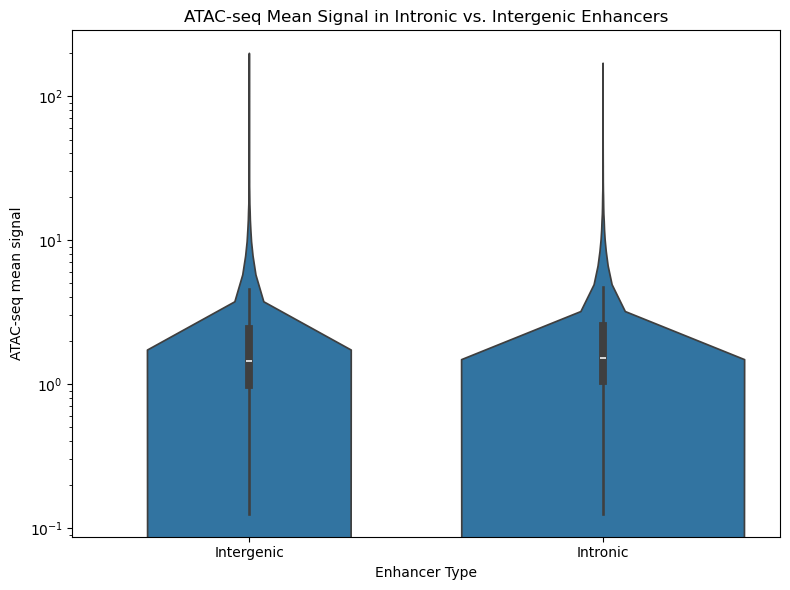

In [49]:
plt.figure(figsize=(8,6))
sns.violinplot(data=enhancers, x="EnhancerType", y="Mean", inner="box")
plt.yscale("log")
plt.title("ATAC-seq Mean Signal in Intronic vs. Intergenic Enhancers")
plt.xlabel("Enhancer Type")
plt.ylabel("ATAC-seq mean signal")
plt.tight_layout()
plt.show()

In [50]:
from scipy.stats import mannwhitneyu

intergenic = enhancers[enhancers["is_intergenic"]]["Mean"]
intronic = enhancers[~enhancers["is_intergenic"]]["Mean"]

stat, p_value = mannwhitneyu(intergenic, intronic)
print(f"Mann-Whitney U Test p = {p_value:.3g}")

Mann-Whitney U Test p = 0


The Mann-Whitney U test shows a result that is below 0.001. this means that the difference between the distributions of the intronic and the intergenic enhancers is significant. 

In [1]:
import pandas as pd
enhancers = pd.read_csv("enhancer_analysis_results.csv")

In [2]:
enhancers.head()

,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss,RegionType,start,end,is_intergenic,EnhancerType,Mean,Median,SD,CV
0,ImmGenATAC1219.peak_1,chr1,3020786,3671498.0,650712.0,Enhancer,3020486,3021086,True,Intergenic,0.807586,0.71,0.720603,0.892293
1,ImmGenATAC1219.peak_2,chr1,3087226,3671498.0,584272.0,Enhancer,3086926,3087526,True,Intergenic,1.135517,0.90,0.920999,0.811084
2,ImmGenATAC1219.peak_3,chr1,3120109,3671498.0,551389.0,Enhancer,3119809,3120409,True,Intergenic,0.688621,0.40,0.745341,1.082369
3,ImmGenATAC1219.peak_4,chr1,3121485,3671498.0,550013.0,Enhancer,3121185,3121785,True,Intergenic,0.788621,0.53,0.882103,1.118539
4,ImmGenATAC1219.peak_5,chr1,3372787,3671498.0,298711.0,Enhancer,3372487,3373087,False,Intronic,0.697586,0.51,0.571493,0.819244


In [5]:
columns_to_keep = ["ImmGenATAC1219.peakID", "chrom", "peak_center",	"closest_tss", "distance_to_tss", "start", "end", "EnhancerType", "Mean"]


In [7]:
enhancers[columns_to_keep].to_csv("enhancer_analysis_results.csv")

TypeError: 'tuple' object is not callable